## Malaria Bounding Box

Malaria is a deadly, infectious, mosquito-borne disease caused by Plasmodium parasites that are transmitted by the bites of infected female Anopheles mosquitoes. There are five parasites that cause malaria, but two types—P. falciparum and P. vivax—cause the majority of the cases.

Malaria is a disease caused by Plasmodium parasites that remains a major threat in global health, affecting 200 million people and causing 400,000 deaths a year. The main species of malaria that affect humans are Plasmodium falciparum and Plasmodium vivax.

For malaria as well as other microbial infections, manual inspection of thick and thin blood smears by trained microscopists remains the gold standard for parasite detection and stage determination because of its low reagent and instrument cost and high flexibility. Despite manual inspection being extremely low throughput and susceptible to human bias, automatic counting software remains largely unused because of the wide range of variations in brightfield microscopy images. However, a robust automatic counting and cell classification solution would provide enormous benefits due to faster and more accurate quantitative results without human variability; researchers and medical professionals could better characterize stage-specific drug targets and better quantify patient reactions to drugs.



## Information About Data

Images are in .png or .jpg format. There are 3 sets of images consisting of 1364 images (~80,000 cells) with different researchers having prepared each one: from Brazil (Stefanie Lopes), from Southeast Asia (Benoit Malleret), and time course (Gabriel Rangel). Blood smears were stained with Giemsa reagent.

Labels
The data consists of two classes of uninfected cells (RBCs and leukocytes) and four classes of infected cells (gametocytes, rings, trophozoites, and schizonts). Annotators were permitted to mark some cells as difficult if not clearly in one of the cell classes. The data had a heavy imbalance towards uninfected RBCs versus uninfected leukocytes and infected cells, making up over 95% of all cells.

A class label and set of bounding box coordinates were given for each cell. For all data sets, infected cells were given a class label by Stefanie Lopes, malaria researcher at the Dr. Heitor Vieira Dourado Tropical Medicine Foundation hospital, indicating stage of development or marked as difficult.


## Problem Statement

1. Given the image data which contains cells of 6 different classes of which 2 classes are of uninfected cells and 4 classes of infected cells. We have to build a model which can localize each object cells in an image with bounding box and detect the class of cells with high confidence score and with high mean average precision.



## Evaluation Metric

In our case we have consider Mean Average Precision Score as a model evaluation metrics.
General idea of how to calculate MAP Score can be get at https://tarangshah.com/blog/2018-01-27/what-is-map-understanding-the-statistic-of-choice-for-comparing-object-detection-models/.

Metrics Intuition:
1. Here we calculate avg precision for each individual classes or categories then calculate mean of all class precision.
https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b

## Refrences
Some nice articles and blogs that we will help in understanding the concept behind yolov3.
1. https://michhar.github.io/learning-from-learning-yolov3/#transfer-learning
2. This one is brilliant blog with explanation and code(pytorch) https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/.
3.From where I have taken refrence of this code and modify as per my needs https://pylessons.com/YOLOv3-introduction/.
4. Dataset can be loaded from https://www.kaggle.com/kmader/malaria-bounding-boxes.

#### Load Modules

In [1]:
from absl import logging
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add,Concatenate,Conv2D,Input,Lambda,LeakyReLU,MaxPool2D,UpSampling2D,ZeroPadding2D,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,TensorBoard
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
import cv2
import pandas as pd
from tqdm import tqdm
import os
import tensorflow as tf
import time
from tqdm import tqdm
import datetime
# from my_yolo import *

#### Loading File

In [2]:
images = os.listdir("../input/malaria-bounding-boxes/malaria/images") # read the images data where all images are present
train = pd.read_json("../input/malaria-bounding-boxes/malaria/training.json") # read the train json file where info about all images
# are given including bounding box information.
test = pd.read_json("../input/malaria-bounding-boxes/malaria/test.json") # read the test json file.

In [3]:
# here we have store train and test image in different list
train_image = [] # train images stored here
test_image = [] # test images stored here
for df in train['image']:
    train_image.append(df['pathname'].split('/')[-1])
for df in test['image']:
    test_image.append(df['pathname'].split('/')[-1])
print("Train image length is -> ",len(train_image))
print("Train image :",train_image[:5])
print("Test image length is -> ",len(test_image))
print("Test image :",test_image[:5])

class_dict = {'red blood cell':0,'trophozoite': 1, 'schizont': 2, 'difficult': 3, 'ring': 4,
              'leukocyte': 5, 'gametocyte': 6}

#class_dict = {'uninfected': 0, 'infected': 1}
# we have defined the dictionary for labels or classes.

Train image length is ->  1208
Train image : ['8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png', '10be6380-cbbb-4886-8b9e-ff56b1710576.png', '6b14c855-8561-417c-97a4-63fa552842fd.png', '13099edb-35d9-438f-b093-2cf2ebf9d255.png', '2559636b-f01a-4414-93da-210c3b12d153.png']
Test image length is ->  120
Test image : ['41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg', '64985a1e-16bb-4016-a01c-c21a5b86e572.jpg', 'c70894fa-50e8-4eed-a5a8-159a20153a49.jpg', 'abb72ce2-4193-4dd3-a34c-61c2ee22ccff.jpg', '8db76867-671a-4488-a7b6-991e4dd2e05f.jpg']


In [4]:

img_info = [] # containg information of bounding box
for row in range(train.shape[0]):
    path = '../input/malaria-bounding-boxes/malaria' + train.iloc[row]['image']['pathname']
    for info in train.iloc[row]['objects']:
        category = info['category'] #  category here refer to label 
        bounding_box = info['bounding_box'] # containing image info like r_min,r_max,c_min,c_max
        box_dim = bounding_box['maximum']['r'],bounding_box['maximum']['c'],bounding_box['minimum']['r'],bounding_box['minimum']['c'],category,path
        img_info.append(box_dim)
for row in range(test.shape[0]):
    path = '../input/malaria-bounding-boxes/malaria' + test.iloc[row]['image']['pathname']
    for info in test.iloc[row]['objects']:
        category = info['category'] #  category here refer to label 
        bounding_box = info['bounding_box'] # containing image info like r_min,r_max,c_min,c_max
        box_dim = bounding_box['maximum']['r'],bounding_box['maximum']['c'],bounding_box['minimum']['r'],bounding_box['minimum']['c'],category,path
        img_info.append(box_dim)
# storing each images info in train_img_info list

import csv
headers = [ 'max_r', 'max_c', 'min_r','min_c', 'category','img_path']
with open('all_data.csv', 'w') as f:
        wr = csv.writer(f, quoting=csv.QUOTE_ALL)
        wr.writerow(headers) 
        wr.writerows(img_info)
# the above code snippet is taking each data and writing it into train csv file.


# after seperating out each cell data in images we have got 80113 cells info.
# here max_r,min_r,max_c,min_c are dimension for each cell which will help us out while cropping that cell in an image.
# so each image contain various malaria cells including all 6 types of cells.
# As we will see in further analysis that RBC has outnumbered other cell categories 

df = pd.read_csv("all_data.csv")

print("This malaria image data contains rows {} and columns {}".format(df.shape[0],df.shape[1]))
df['label'] = df['category'].map(class_dict) 

data = df


This malaria image data contains rows 86035 and columns 6


#### Data Exploration

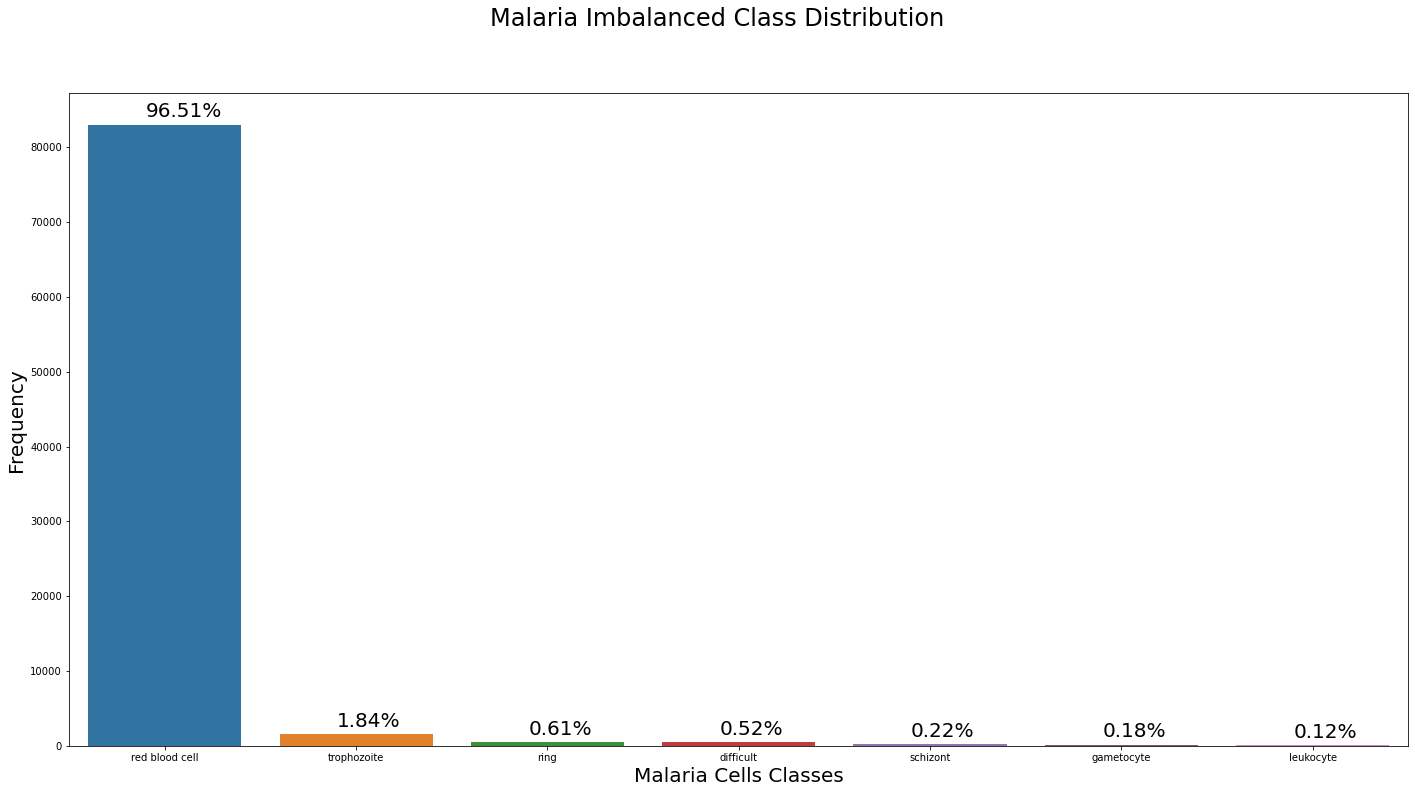

In [5]:
# this is a class distribution 
fig,ax = plt.subplots(figsize=(24,12))
temp = data['category'].value_counts().values
sns.barplot(x = data['category'].value_counts().index.tolist(),y = data['category'].value_counts().values.tolist())
for i,text in enumerate(data['category'].value_counts(normalize = True).items()):
    ax.annotate("{:.2f}%".format(text[1]*100),xy = (i-0.10,temp[i]+1000),fontsize = 20)
plt.xlabel("Malaria Cells Classes",fontsize = 20)
plt.ylabel("Frequency",fontsize = 20)
plt.suptitle("Malaria Imbalanced Class Distribution",fontsize = 24)
plt.show()


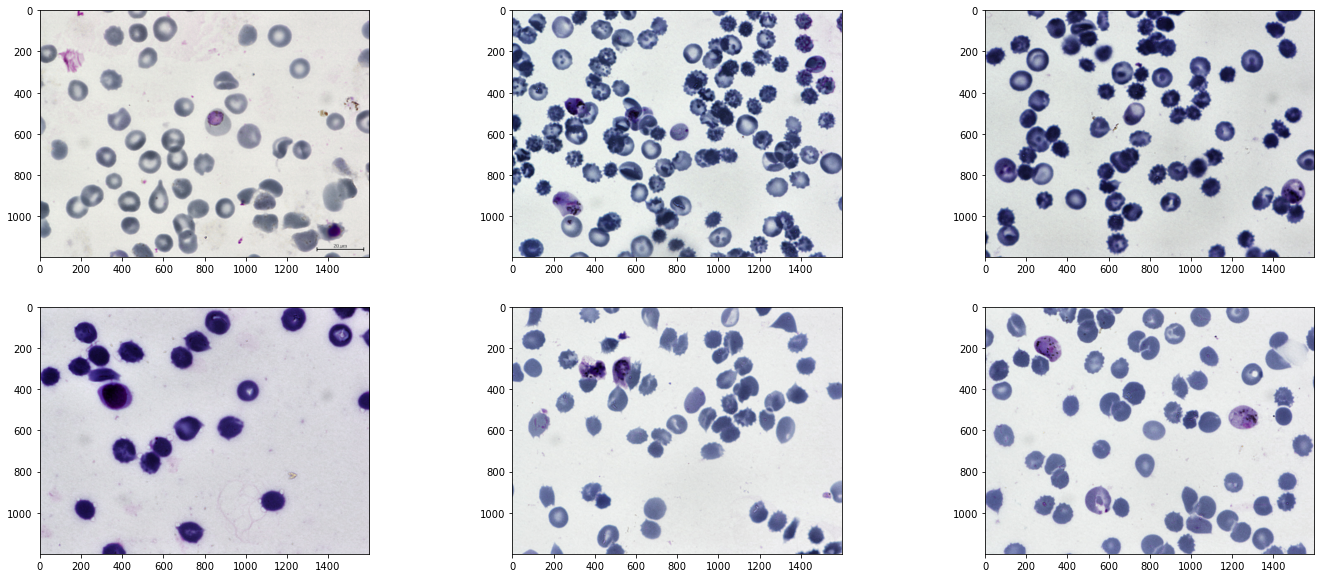

In [6]:
plt.figure(figsize = (24,10))
count=1
for row in list(np.random.choice(train.shape[0],6)): # taking 6 random index inputs and displaying the image
    path = '../input/malaria-bounding-boxes/malaria' + train.iloc[row]['image']['pathname']
    im = Image.open(path)
    plt.subplot(2,3,count)
    plt.imshow(im)
    plt.grid(False)
    count+=1


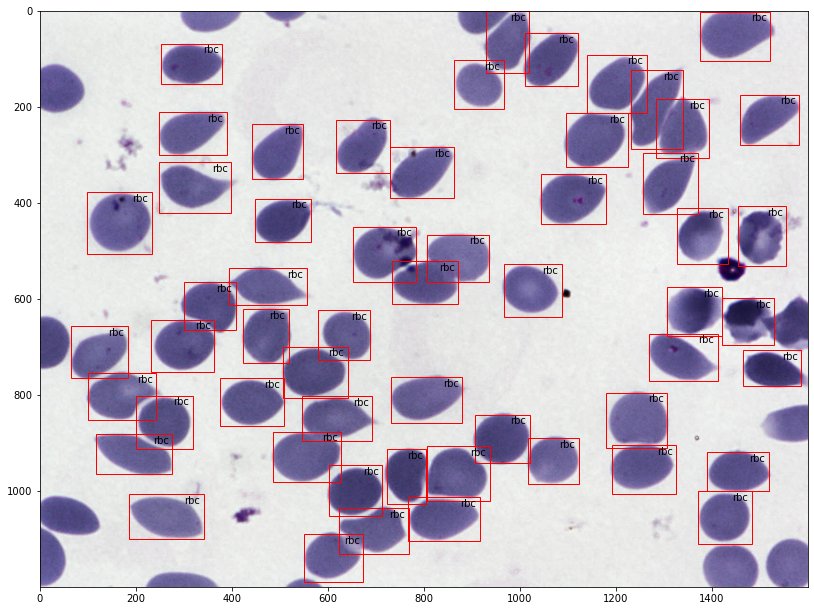

In [7]:
from matplotlib import patches
fig = plt.figure(figsize = (24,8))

ax = fig.add_axes([0,0,1,1])
row = np.random.choice(train.shape[0],1)[0]
path = '../input/malaria-bounding-boxes/malaria' + train.iloc[row]['image']['pathname']
image = plt.imread(path)
plt.imshow(image)

for _,row in data[data.img_path==path].iterrows():
    xmin = row.min_c # x1
    xmax = row.max_c # x2
    ymin = row.min_r # y1
    ymax = row.max_r # y2

    l = xmax-xmin # x2-x1
    b = ymax-ymin # y2-y1

    if row.category=='red blood cell':
        color='r' # bounding box color for RBC
        ax.annotate('rbc',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='trophozoite':
        color='g' # bounding box color for trophozoite
        ax.annotate('trophozoite',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='difficult':
        color='b'# bounding box color for difficult
        ax.annotate('difficult',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='ring':
        color='r' # bounding box color for ring
        ax.annotate('ring',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='schizont':
        color='r' # bounding box color for schizont
        ax.annotate('schizont',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='gametocyte':
        color='o' # bounding box color for gametocyte
        ax.annotate('gametocyte',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='leukocyte':
        color='b' # bounding box color for Leukocyte
        ax.annotate('leukocyte',xy=(xmax-40,ymin+20)) # bonding box dimension

    rect = patches.Rectangle((xmin,ymin), l, b, edgecolor = color, facecolor = 'none')
    ax.add_patch(rect)


# rbc and leukocyte are uninfected cells
# and other four classes trophozoite,difficult,ring,schizont are infected cells.


#### Initializing Important Variables

In [8]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

size = 416 # size of resize image
batch_size = 8
yolo_max_boxes = 223 # maximum yolo boxes predicted per image i.e output shape: (batch_size,223,4)

# here "yolo_max_boxes" means information of bounding box dimension of number of object contains in an image 
# It's just like padding if we have image containing 73 objects then rest(223-73 = 150) will be padded with [0,0,0,0]
# There are 4 index in a list i.e xcent,ycent,width,height


yolo_iou_threshold = 0.5 # IOU threshold score 
yolo_score_threshold = 0.4 # objectness threshold score
learning_rate = 1e-4 # learning rate
num_classes = 7 # num of category in our dataset
epochs = 100 # epochs run to fine tune our model

### Yolov3 Model

In [9]:
## we are going to use functional API, as sequential API can be somewhat messy for such architecture implementation.

# below is simple implementation of each convolutional Layer in Darknet. We have created
# one function for simple convolutional layer and one function for residual connection

def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1: # if stride is 1 then we apply 'same' padding
        padding = 'same' # i.e which output same shape as input if we input = (416,416) then output will also be (416,416)
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding 
        padding = 'valid' 
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x) # by default alpha is 0.3
    return x

# below is residual connection layer function
def DarknetResidual(x, filters):
    prev = x # storing input in prev variable 
    x = DarknetConv(x, filters // 2, 1) 
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x]) # residual connection
    return x

# this is our real Darknetblock function calling above 2 fucntions 
def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2) 
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

# the below x_36,x_61 and x are outputs which we will use in next function for upsampling and detecting objects.
# x : used for detecting large objects i.e having grid_size of (13,13)
# x_61 : used for detecting medium size objects i.e having grid_size of (26,26)
# x_36 : used for detecting small objects i.e having grid_size of (52,52)

def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4) # last layer detecting bounding box dimension (tx,ty,bx,by)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [10]:
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            # upsampling of a layer
            x = UpSampling2D(2)(x)
            # concatenation of skip connection result and last output result
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
        
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

### Yolo Output,Loss Function and Non-Maximum Suppression.

In [11]:
# below function is yolov3 output i.e last 3 convolution layer which will predict anchors 
# objectness score, tx,ty,tw,th which we will use in some operation to learn xcent,ycent and width,height.
# which is clearly mention in https://pjreddie.com/media/files/papers/YOLOv3.pdf paper.


def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:]) # this is an input shape excluded with batch size.
        x = DarknetConv(x, filters * 2, 3) # Darkconv is a fn implemented above which is internally calling
        
        # DarknetBlock, which internally calling DarknetConv,DarknetResidual fn.
        # It's a simple nested functions which we have learned in python or c++.

        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        # x is reshaped into (None, grid_size, grid_size, anchors, (x,y,w,h,objectness score,..classes))
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output


# for more help in understanding how yolov3 works go to https://pylessons.com/YOLOv3-introduction/

# this fn helps in predicting for each of predicted yolo boxes objectness scores, x,y,w,h.
# Remember last layer is a sigmoid layer and not a softmax layer.

def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)
    # objectness : it's means whether there is any object in a predicted box
    # class_probs : it's a probability of a class given object is there i.e P(Pc|object)

    box_xy = tf.sigmoid(box_xy) 
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    # Below is the operation of predicting true dimension in an image
    # bx=σ(tx)+cx
    # by=σ(ty)+cy
    # bw=pw.e^tw
    # bh=ph.e^th

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2 
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box

# below nms function will suppressed those bounding box result which is not effective on the basis of
# yolo_maximum_threshold(IOU) and objectness score.

def yolo_nms(outputs, anchors, masks, classes):
    # boxes, confidence scores(objectness scores), class probabilities

    b, c, t = [], [], []

    # iterating through each outputs predicted by model
    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs # this is P(Pc|objectness score) value

    # this is beautifull implementation of nms code
    # https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression

    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class = yolo_max_boxes, # here it is 223, define above 
        max_total_size = yolo_max_boxes,
        iou_threshold = yolo_iou_threshold, # threshold for filtering the boxes
        score_threshold = yolo_score_threshold # threshold for objectness score below which we ignore that bounding box
    )

    return boxes, scores, classes, valid_detections

# this is main function for our backbone or darknet archietcture which calls above implemented functions
# 
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels], name='input') # input of an image

    x_36, x_61, x = Darknet(name='yolo_darknet')(x) # backbone networks 3 outputs w.r.t to each grid size
    # till here darknet network

    # from below it's a Feature Pyramind Network with lateral connections
    # for 13*13 grid size output
    x = YoloConv(512, name='yolo_conv_0')(x) 
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)
    
    # for 26*26 grid size output
    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    # for 52*52 grid size output
    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    # for 13*13 grid size output
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    # for 26*26 grid size output
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    # for 52*52 grid size output
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)
    #  after combining boxes from various scales we have total 10,647 boxes which is too large
    # so to remove invalid boxes we use non_maximum_suppression 

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')


In [12]:
# below is a yolo loss function (both categorical loss function and mean square error)
# we have calculated each individual loss and summed at last.
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1) 

        # the above split function split (x1,y1,x2...cls) into (x1,y1),(x2,y2),(obj),(cls)
        # the 4,1,1 is a length at which it split

        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2 # finding center (Xcen,Ycen)
        true_wh = true_box[..., 2:4] - true_box[..., 0:2] # width and height

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32) # this code snippet giving us at which point each cell is starting and ending
            # in resize image of 416 * 416 
            # suppose there 13*13 = 169 cells , so every cell we will have starting and ending point
        true_wh = tf.math.log(true_wh / anchors) 
        # YOLO doesn’t predict the absolute coordinates of the bounding box’s center
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        
        # ignore false positive when iou is over threshold
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1),
            (pred_box, true_box, obj_mask),
            tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        # obj_loss = obj_mask * obj_loss + \
        #     (1 - obj_mask) * ignore_mask * obj_loss

        # below we implemented focal loss so that all the false negative weights can be down weight
        # and our model can learn from actual loss.
        
        # https://leimao.github.io/blog/Focal-Loss-Explained/
        
        alpha = 0.85 # focal loss hyperparameter
        conf_focal = tf.pow(obj_mask-tf.squeeze(tf.sigmoid(pred_obj),-1),2)
        obj_loss = conf_focal*((1-alpha)*obj_mask*obj_loss + alpha*(1-obj_mask)*ignore_mask*obj_loss)  # batch * grid * grid * anchors_per_scale

        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

### Utils Function

In [13]:
YOLOV3_LAYER_LIST = ['yolo_darknet','yolo_conv_0','yolo_output_0','yolo_conv_1',
                     'yolo_output_1','yolo_conv_2','yolo_output_2',]

# Below function will help in load darknet weights which is already saved.
# it can be yolov3 weights or fine tune model weights

def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb') # reading weights file
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    layers = YOLOV3_LAYER_LIST

    # iterating through all layers define in above yolov3_layers_list
    for layer_name in layers:
        # for eg if there is one layer darknet then there is many sub layers inside it's network
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'): 
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

# below function will calculate Intersection over Union ratio which help in above nms function.
# it's implemented in such a way which is self-explanatory.

def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape) # it will change the shape of box into new_shape given
    box_2 = tf.broadcast_to(box_2, new_shape)

    # in below code we are finding intersection box width and height through which we will find intersection area.
    # and this we are finding all boxes 
    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0) 
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0) 
    int_area = int_w * int_h  # area of intersection
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1]) # this box_1_area contains all boxes area predicted in an image
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1]) # this box2_area is our ground truth box area

    # Formula: Union(A,B) = A + B - Inter(A,B)
    return int_area / (box_1_area + box_2_area - int_area)

# below function will help in comparing the results when we visualize it after we have pre-trained our model.

def draw_outputs(img, outputs, class_names,no_rbc = True):
    boxes, objectness, classes, nums = outputs # predicted outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    # iterate through each valid predictions
    for i in range(nums):
        if no_rbc:
            if classes[i]==0:
                continue 
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32)) # 
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2) # it will create a rectangle box around object.
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2) # help it displaying text of 
            # predicted class with objectness score*class_probabilities
    return img

# below this function helps in freeze the layers i.e making it non-trainable
# here in our case we pre-training darknet layer.

def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

### Data Loader And Transformation

In [14]:
%%time
# below function parse the created csv file and structured into yolo acceptable format
# data : dataframe which was created above
# class_dict: dictionary containing classes with index(created above)
# size : Input size of each image (here by default is 416)
# path : path to images data folder

def parse_dataset(data,class_dict,size,image,path,yolo_max_boxes,count=0):
    X = []
    Y = []
    # iterating over all images in a train dataset
    for img in tqdm(image):
        x_train = Image.open(path+img) # reading image
        width,height = x_train.size # storing actual width and height so that we can later scale it
        x_train = x_train.resize((size,size)) # resizing 
        x_train = np.array(x_train)
        temp_data = []
        # ierating over dataset having info about objects in an image
        for _,row in data[data['img_path']==path+img].iterrows():
            xmin = row.min_c/width
            xmax = row.max_c/width
            ymin = row.min_r/height
            ymax = row.max_r/height
            cls = class_dict[row.category]
            temp_data.append([xmin,ymin,xmax,ymax,cls])
        temp_data = temp_data+[[0,0,0,0,0]]*(yolo_max_boxes-len(temp_data)) # it's like padding 
        #return(temp)
        Y.append(temp_data)
        X.append(x_train)
    return(np.array(X),np.stack(np.array(Y)))

# transforming each image and normalizing it in range [0,1]
def transform_images(x,size):
    x = tf.image.resize(x,(size,size))
    x = x/255.0
    return(x)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.7 µs


In [15]:
#https://www.tensorflow.org/guide/function 
# https://towardsdatascience.com/tensorflow-2-0-tf-function-and-autograph-af2b974cf4f7 


@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x, y, w, h, obj, class])
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0

    # below iteration change the values and update it to the format which acceptable by yolov3.
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0): 
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4] #(x1,y1,x2,y2)
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2 # ((x1+x2)/2,(y1+y2)/2)

                # which is (Xcenter,Ycenter)

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32) # multiplying it by grid_size

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]]) 
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    # https://www.tensorflow.org/api_docs/python/tf/tensor_scatter_nd_update
    # below function helps in updating passed in y_true_out by updating values at passed in indexes
    # with updates values.
    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


In [16]:
def transform_targets(y_train, anchors, anchor_masks, size):
    y_outs = []
    grid_size = size // 32 # suppose we input 416 size then grid size is 416//32 = 13

    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32) # casting every anchors to float
    anchor_area = anchors[..., 0] * anchors[..., 1] # calculating the area of anchors
    box_wh = y_train[..., 2:4] - y_train[..., 0:2] # here we are peforming xmax-xmin,ymax-ymin using vectors
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1] # these are our Ground Truth Box Area
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1]) # here we tring to get IOU area 
    iou = intersection / (box_area + anchor_area - intersection) # simple operation of Intersection/Union
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32) # storing those anchor index which has highest IOU number
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2 # here we are calling the above function for 13*13 grid then, 26*26 grid then, 52*52 grid.

    return tuple(y_outs)

### Loading Yolov3 weights into Model

In [17]:
%%time
# below we are loading or converting yolov3 weights in a format which we have defined above.
yolo = YoloV3(classes=80)
yolo.summary()
#load_darknet_weights(yolo,"/content/drive/My Drive/yolov3.weights", False)
#yolo.save_weights("/content/drive/My Drive/yolov3_checkpoint/yolov3.tf")
yolo.load_weights("../input/yolov3-tf-pretrained/yolov3.tf")

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, None, None, 5 11024384    yolo_darknet[1][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, None, None, 2 2957312     yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][1]          

In [18]:
x,y= parse_dataset(
   df,class_dict,size,train_image[:],'../input/malaria-bounding-boxes/malaria/images/',223) 
# df = data
x = x.astype(np.float32)
y = y.astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x,y))

100%|██████████| 1208/1208 [02:31<00:00,  7.97it/s]


In [19]:
# buffer_size helps to randomized the data for training
train_dataset = train_dataset.shuffle(buffer_size=64)
# this is a batch_size that we are using to train our model.
train_dataset = train_dataset.batch(8)
# after taking batch of images we map them to transform into particular scale and particular format
# which is acceptable by yolov3 for training. 
train_dataset = train_dataset.map(lambda x, y: (transform_images(x, size),
                                  transform_targets(y, yolo_anchors, yolo_anchor_masks, size)))
# prefetch try to spped up thinks by prefetching next batch of images and performing operation on it.
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function transform_images at 0x7fbc5e809560>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### Validataion Dataset

In [20]:
# parsing valid dataset 
x,y= parse_dataset(df,class_dict,size,test_image[:],'../input/malaria-bounding-boxes/malaria/images/',223) 
x = x.astype(np.float32)
y = y.astype(np.float32)
val_dataset = tf.data.Dataset.from_tensor_slices((x,y))

100%|██████████| 120/120 [00:17<00:00,  7.00it/s]


In [21]:
val_dataset = val_dataset.shuffle(buffer_size=16)
val_dataset = val_dataset.batch(8)
val_dataset = val_dataset.map(
    lambda x, y: (transform_images(x, size),
    transform_targets(y, yolo_anchors, yolo_anchor_masks, size)))

val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#### Model Training Started

In [22]:
# initializing the network
model = YoloV3(size, training=True, classes=num_classes)
anchors = yolo_anchors
anchor_masks = yolo_anchor_masks

In [23]:
%%time

model_pretrained = YoloV3(size, training=True, classes=80)
model_pretrained.load_weights("../input/yolov3-tf-pretrained/yolov3.tf")
 # first loading yolov3 weights in out pretrained model
# getting weights of yolo_darknet as we are going to fine tuning we are freezing all layers in the
# darknet. To make it non-trainable.
model.get_layer('yolo_darknet').set_weights(
model_pretrained.get_layer('yolo_darknet').get_weights())
freeze_all(model.get_layer('yolo_darknet'))

CPU times: user 10.3 s, sys: 463 ms, total: 10.7 s
Wall time: 9.91 s


In [24]:
 # we are using graph mode of tensorflow so that we can use our own Gradient Tape
optimizer = tf.keras.optimizers.Adam(lr=1e-4) # Adam optimizers
loss = [YoloLoss(anchors[mask], classes=num_classes) # customized yolo loss define above in utils.
            for mask in anchor_masks]

#### Calculating Loss using Gradient Tape

In [25]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
# train and testd log directory for tensorboard where we going to write ouw own custom summary.

train_log_dir = '416_logs/gradient_tape/' + current_time + '/train' # train dir path
test_log_dir = '416_logs/gradient_tape/' + current_time + '/test' # test dir path
#all_log_dir = 'logs/gradient_tape/' + current_time + '/all'
train_summary_writer = tf.summary.create_file_writer(train_log_dir) # train writer
test_summary_writer = tf.summary.create_file_writer(test_log_dir) # test writer
#all_summary_writer = tf.summary.create_file_writer(all_log_dir)

In [26]:
# Eager mode is great for debugging
# Non eager graph mode is recommended for real training

avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

# below is a checpoint manager which will help in recording our loss of last 3 checkpoints
# If suppose your training stop for some reason it can reload latest checkpoint and start from there
# this really helps in synching of checpoints and tensorboard
# step variable below helps in recording steps

ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model = model)
manager = tf.train.CheckpointManager(ckpt, '416_checkpoints/yolov3_train/tf_ckpts', max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

if manager.latest_checkpoint:
  # if there is a checkpoint in a file it will restore it.
    print("Restored from {}".format(manager.latest_checkpoint))
    start = ckpt.step.numpy() 
else:
    print("Initializing from scratch.")
    start = 0

  
for epoch in range(start, epochs+1):
    
    # training dataset
    # if epoch%22==0 and epoch!=0:
    #   lr = float(input("Input Learning Rate"))
    #   optimizer = tf.keras.optimizers.Adam(lr=lr)
    for batch, (images, labels) in enumerate(train_dataset):
        
        # we are using tf.GradientTape to record every values at each step and later use it to
        # calculate our gradient and losses.
        # https://stackoverflow.com/questions/53953099/what-is-the-purpose-of-the-tensorflow-gradient-tape
        with tf.GradientTape() as tape:
            outputs = model(images, training=True)
            regularization_loss = tf.reduce_sum(model.losses)
            pred_loss = []
            for output, label, loss_fn in zip(outputs, labels, loss):
                pred_loss.append(loss_fn(label, output))
            total_loss = tf.reduce_sum(pred_loss) + regularization_loss
        # calculating grads over trainable parameters
        grads = tape.gradient(total_loss, model.trainable_variables) # calculating loss after each batch 
        optimizer.apply_gradients(
            zip(grads, model.trainable_variables)) # then appliying gradient optimization on the loss to fine tune the weights 

        # writing summary to train file(for tensorboard)

        with train_summary_writer.as_default():
            tf.summary.scalar('avg_loss', total_loss.numpy(), step=epoch)
        # to update avg loss after each batch.
        avg_loss.update_state(total_loss)
    
    # testing datasets
    for batch, (images, labels) in enumerate(val_dataset):
        outputs = model(images)
        regularization_loss = tf.reduce_sum(model.losses)
        pred_loss = []
        for output, label, loss_fn in zip(outputs, labels, loss):
            pred_loss.append(loss_fn(label, output))
        total_loss = tf.reduce_sum(pred_loss) + regularization_loss

        # writing summary to test file(for tensorboard)

        with test_summary_writer.as_default():
            tf.summary.scalar('avg_val_loss', total_loss.numpy(), step=epoch)
        avg_val_loss.update_state(total_loss)

    # print result 
    print("{}, train: {}, val: {}".format(
        epoch,
        avg_loss.result().numpy(),
        avg_val_loss.result().numpy()))
    
    ckpt.step.assign_add(1)
    if int(ckpt.step) % 5 == 0:
        save_path = manager.save()
        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

    avg_loss.reset_states()
    avg_val_loss.reset_states()

Initializing from scratch.


* I haven't trained it from beginning as it will take time to get the model ready.
* I have trained my model for 100 epochs, and after every 5 steps it keep saving the best 3 checkpoints.
* It also stores the steps you ran before getting disconneted due to any issue and start from where it has stopped.

#### Tensorboard

In [ ]:
# running tensorboard 
# https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
%load_ext tensorboard
%tensorboard --logdir 416_logs

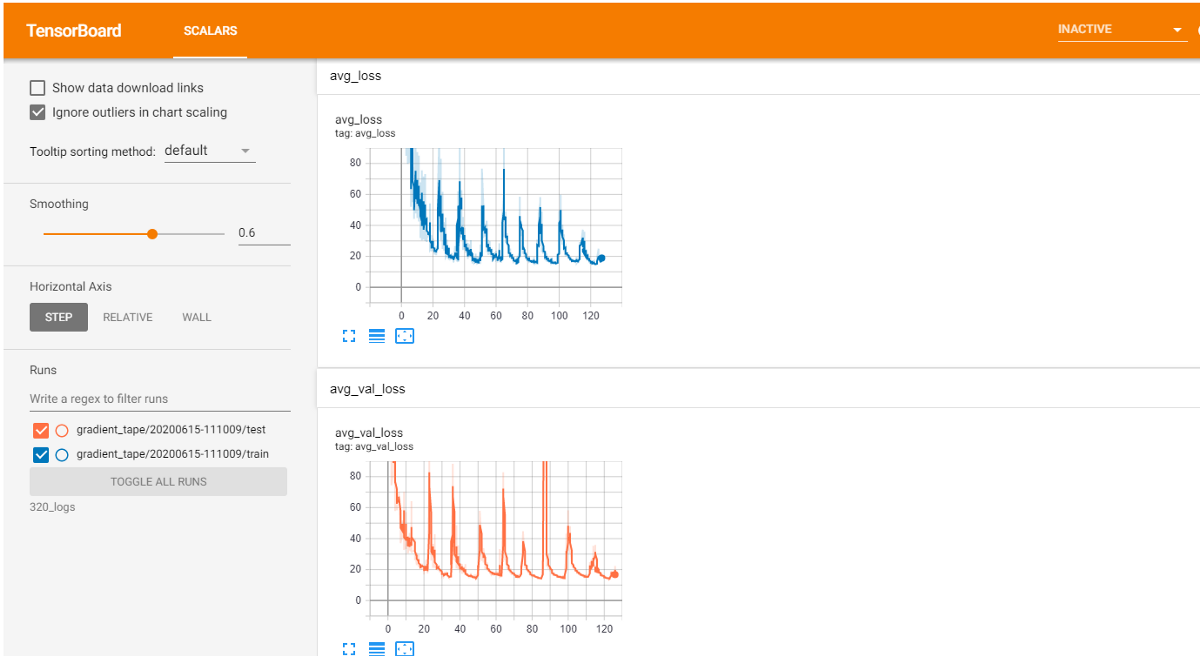

### Results or Testing

In [ ]:
# below function draws grounf truth boxes
class_names = {j:i for i,j in class_dict.items()}
def draw_gt_outputs(path, data, class_names,no_rbc = True):
    img = plt.imread("malaria/images/"+path)
    wh = np.flip(img.shape[0:2])
    # iterate through each valid predictions
    nums,classes = [],[]
    for _,row in data[data.img_path=="malaria/images/"+path].iterrows():
        xmin = row.min_c # x1
        xmax = row.max_c # x2
        ymin = row.min_r # y1
        ymax = row.max_r # y2
        nums.append([xmin,ymin,xmax,ymax])
        classes.append(row.label)
    nums = np.array(nums)
    for i in range(nums.shape[0]):
        if no_rbc:
            if classes[i]==0:
                continue 
        x1y1 = tuple((np.array(nums[i][0:2])).astype(np.int32)) # 
        x2y2 = tuple((np.array(nums[i][2:4])).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2) # it will create a rectangle box around object.
        img = cv2.putText(img, '{}'.format(
            class_names[int(classes[i])]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2) # help it displaying text of 
            # predicted class with objectness score*class_probabilities
    return img

In [ ]:

def predict(data,indx,weights_path = '/content/drive/My Drive/320_checkpoints/yolov3_train/tf_ckpts',visualize = False,no_rbc = True):
  # data : train_image or test_image
  
    yolo = YoloV3(classes=num_classes)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model = yolo)
    manager = tf.train.CheckpointManager(ckpt,weights_path, max_to_keep=3)
    ckpt.restore(weights_path + '/ckpt-17')

    #yolo.load_weights(weights_path).expect_partial()

    class_names = list(class_dict.keys())

    img_raw = tf.image.decode_image(
    open('malaria/images/'+data[indx], 'rb').read(), channels=3)

    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, size)
    img1 = img[0][:]
    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names,no_rbc)

    if visualize:
    plt.suptitle("Ground Truth vs Predicted",fontsize = 20)
    plt.figure(figsize=(24,8))
    plt.subplot(1,2,1)
    plt.title("Image Name (Predicted) {}".format(data[indx]))
    gt_img = draw_gt_outputs(data[indx],df,class_names,no_rbc)
    plt.imshow(gt_img)
    plt.subplot(1,2,2)
    plt.title("Image Name (Predicted) {}".format(data[indx]))
    plt.imshow(img)
    # return(img)


    else:
    return( [boxes, scores, classes, nums])
    # cv2.imwrite("res.jpg", img)

### Below displayed is a result of my YoloV3 Model

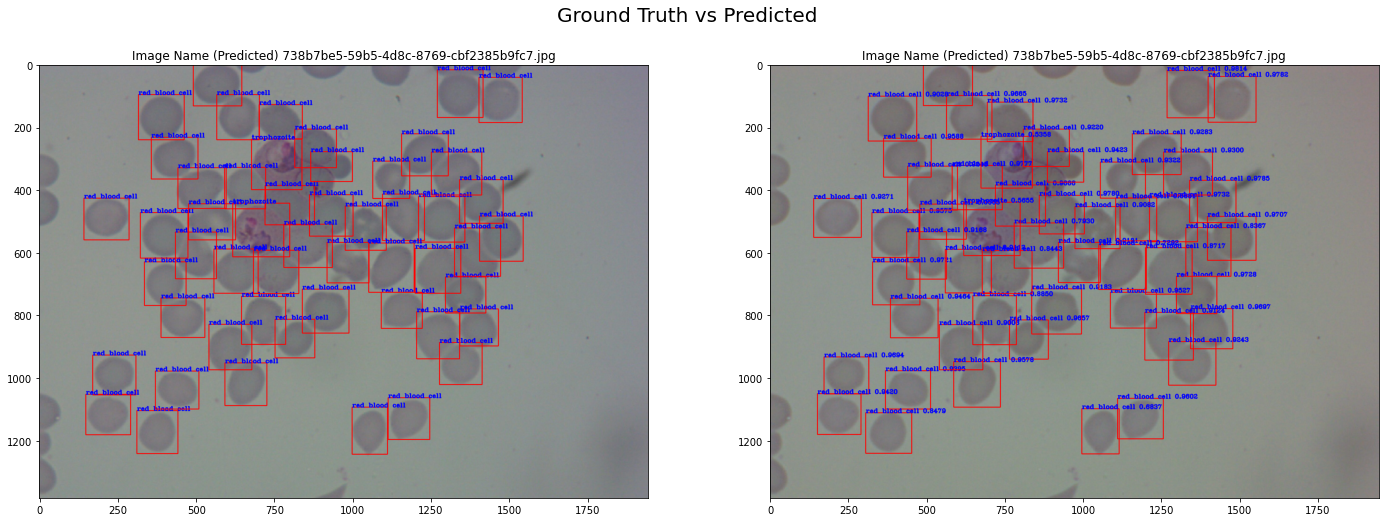

In [3]:
from IPython.display import Image
Image("../input/malaria-image/download (1).png")

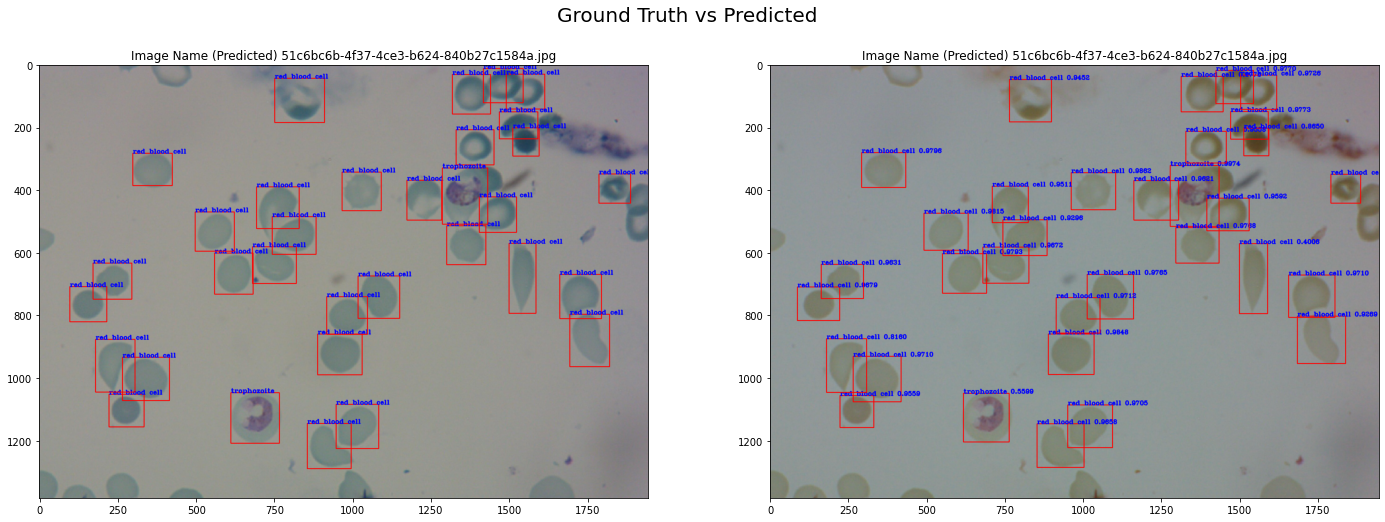

In [4]:
Image("../input/malaria-image/download (2).png")

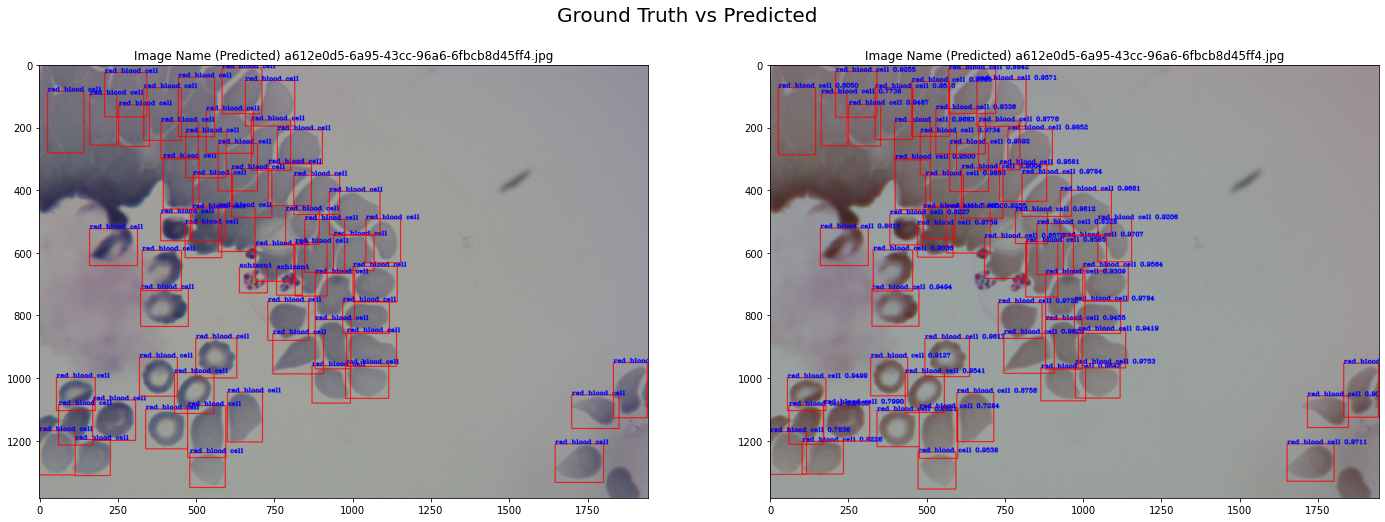

In [5]:
Image("../input/malaria-image/download (3).png")

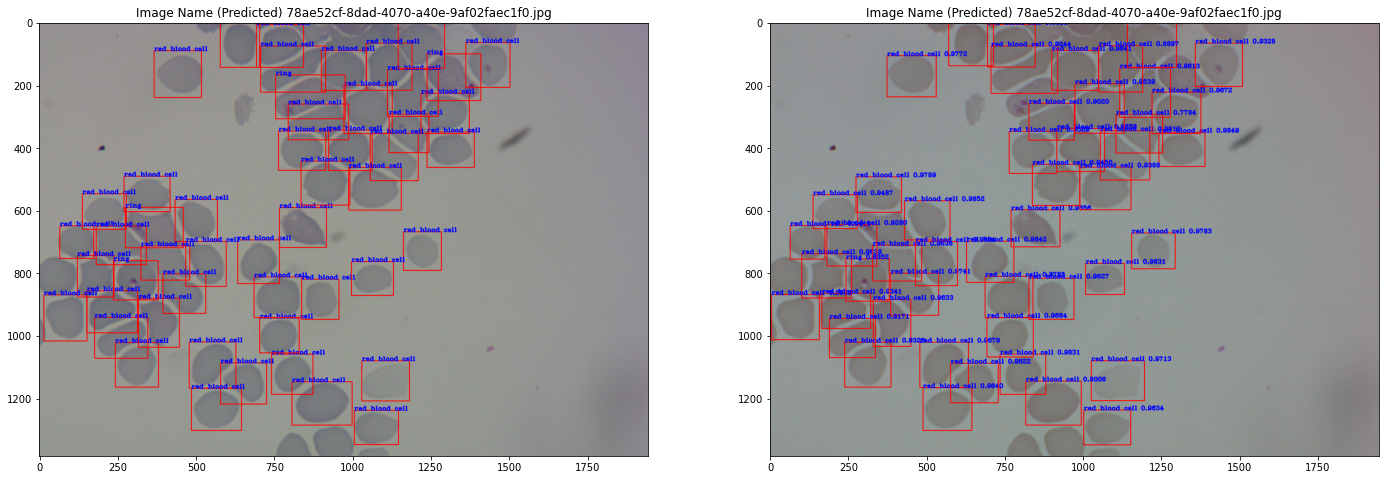

In [6]:
Image("../input/malaria-image/download (4).png")

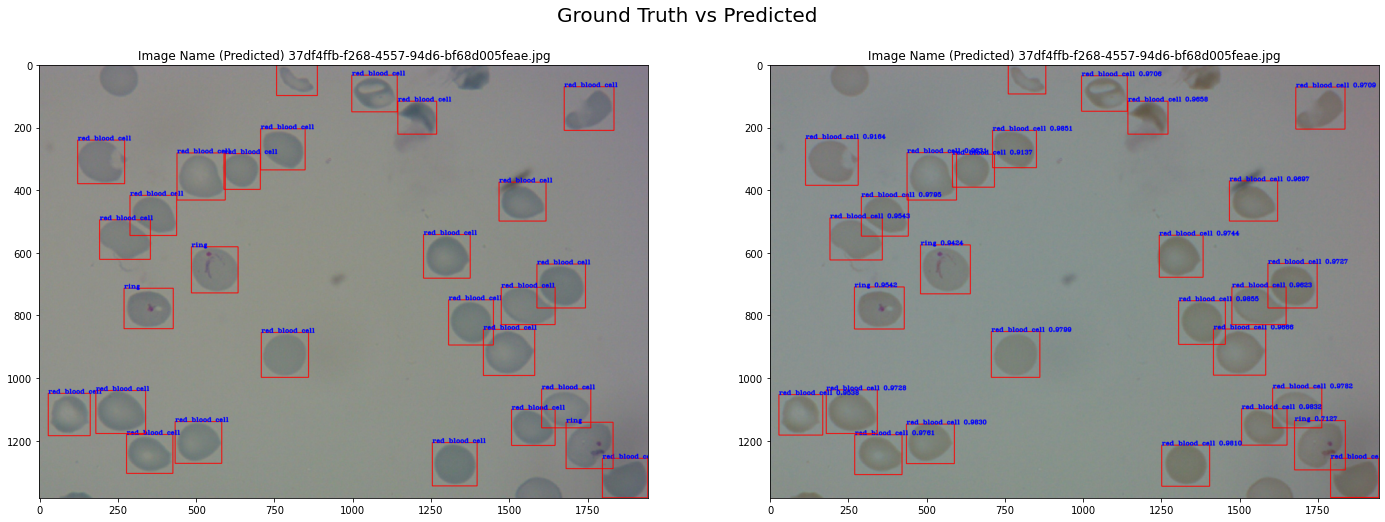

In [7]:
Image("../input/malaria-image/download (5).png")

#### Conclusion
1. Dataset is highly **imbalaced data** with 96% of RBC cells and other 4% for 5 categories.
2. When using categorical **cross entropy loss** for negative samples i.e Bounding box for which there is no object is to high and loss for positive samples is too low for which our optimizers tries to lower negative samples loss as it's higher.Therefore, our model wasn't working well at detections.
3. So to overcome the above hurdle we have tried **focal loss** which try to down weight **negative sample loss** and hence improve our model performace.
4. If there is more data for all categories(except RBC) our model could have performed much better.
5. For this model I have taken alpha parameter of **focal loss 0.85**, I have also tried 0.70,0.75,0.80 but at last 0.85 suited best for this model.


## So, This concludes my work. Thank you for reading it............ I hope you enjoyed it.......... pls do upvote....